# American Community Survey (PUMS) Wage Analysis

**Sections:**
1. Introduction <br/>
    1.1 Importing Data Files (2018 - 2008) <br/>
    1.2. Initial Data Analysis <br/>
2. Data Selection <br/>
    2.1. Full-Time Detection <br/>
    2.2. Outlier <br/>
3. Feature Transformation <br/>
    3.1. Age Bins <br/>
    3.2. Education Categorization <br/>
    3.3. Occupation Grouping <br/>
    3.4. State Observations <br/>
    3.5. Race <br/>
4. Dataframe Management <br/>
    4.1. Remove Columns <br/>
    4.2. OHE Columns <br/>
5. Preprocessing Pipeline <br/>
6. Modeling <br/>
    6.1. Random Forest <br/>
    6.2. Feature Selection <br/>
7. Analysis <br/>
    7.1. Scoring Rational <br/>
    7.2. Year to Year Analysis <br/>
    7.3. Simple Wage Predictor <br/>


# 1. Introduction
American Community Survey (ACS) Public Use Microdata Sample (PUMS) shows a range of individual information on the US in separate years. Each year's worth of data is recorded in single rows of individuals which represents about one percent of the US population. It is assumed that the over a five-year period, year year's information should cover five percent of the US population.

The information collected covers features from each person such as weight, age, education, housing situation, children and parent status, and more. These areas are all coded to numerical values which out outlined in the data directory which includes all coded values. Full data and documentation can be located at https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.html for years readily available between 2005 and 2018.

The goal of this information is the accumulate the data from specified features to output a single score which reflects the wage difference between men and females while normalizing for age, education, industry, region, and race. While there are certainly difference between each subsection as to how large the difference is, this score looks to encapsulate the differences for the entire US.

## 1.1. Importing Data Files (2018 - 2008)

These datafiles are large (2 GB for each year) and contain multiple columns which are not observed in this study. Therefore, given the plethora of data, only half of the years (initially only 2018) were visualized and analyzed for creating a model. Overall, columns chosen were assumed to show the most correlation between wage and signs of difference between gender.

In [1]:
# Importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import statistics
import glob
import time

In [2]:
years = list(r*2 for r in range(1004, 1010))
PUS_start = pd.DataFrame()
start_time = time.time()
for year in years:
    useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
                   'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST']
    path = ('data/%s' % year)
    PUS_split = pd.concat([pd.read_csv(f, usecols=useful_cols)
                           for f in glob.glob(path + "/*.csv")], ignore_index=True)
    PUS_start = PUS_start.append(PUS_split)
print(PUS_start.shape)
print(" %s min" % round(((time.time() - start_time)/60), 2))

(18679015, 10)
 3.71 min


## 1.2. Initial Data Analysis

In [3]:
PUS_start.columns

Index(['ST', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'OCCP', 'POWSP',
       'RAC1P'],
      dtype='object')

In [4]:
PUS_start.describe(include='all')

ST          AGEP          SCHL           SEX          WAGP  \
count  1.867902e+07  1.867902e+07  1.808252e+07  1.867902e+07  1.593322e+07   
mean   2.765467e+01  4.056208e+01  1.585766e+01  1.512292e+00  2.566373e+04   
std    1.603227e+01  2.352116e+01  5.660316e+00  4.998489e-01  4.782771e+04   
min    1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.200000e+01  2.000000e+01  1.400000e+01  1.000000e+00  0.000000e+00   
50%    2.700000e+01  4.100000e+01  1.700000e+01  2.000000e+00  5.000000e+03   
75%    4.200000e+01  5.900000e+01  2.000000e+01  2.000000e+00  3.600000e+04   
max    5.600000e+01  9.600000e+01  2.400000e+01  2.000000e+00  7.180000e+05   

               WKHP           WKW          OCCP         POWSP         RAC1P  
count  1.116149e+07  9.622696e+06  1.103743e+07  8.397553e+06  1.867902e+07  
mean   3.284190e+01  1.899983e+00  4.340872e+03  2.800783e+01  1.860106e+00  
std    1.798892e+01  1.631469e+00  2.620540e+03  1.795425e+01  2.067998e+00  
min    0.000000e+00  1.000000e+00  1.000000e+01  1.000000e+00  1.000000e+00  
25%    2.000000e+01  1.000000e+00  2.310000e+03  1.200000e+01  1.000000e+00  
50%    4.000000e+01  1.000000e+00  4.400000e+03  2.700000e+01  1.000000e+00  
75%    4.000000e+01  2.000000e+00  5.740000e+03  4.200000e+01  1.000000e+00  
max    9.900000e+01  6.000000e+00  9.920000e+03  5.550000e+02  9.000000e+00

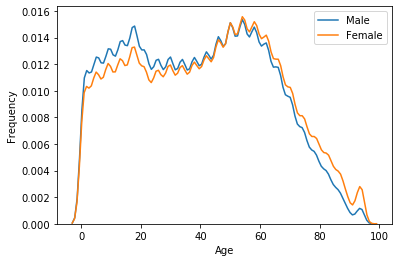

In [5]:
g = sns.kdeplot(
    PUS_start["AGEP"][(PUS_start["SEX"] == 1) & (PUS_start["AGEP"].notnull())])
g = sns.kdeplot(
    PUS_start["AGEP"][(PUS_start["SEX"] == 2) & (PUS_start["AGEP"].notnull())])
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Male", "Female"])

Text(0, 0.5, 'Frequency')

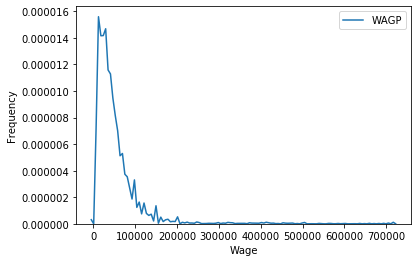

In [6]:
g = sns.kdeplot(PUS_start["WAGP"]
                [(PUS_start["WAGP"] > 0) & (PUS_start["AGEP"] > 18)])
g.set_xlabel("Wage")
g.set_ylabel("Frequency")

# 2. Data Selection
## 2.1. Full-Time Detection

Before analyzing the data, first the scope of people observed were reserved for those working full time and in the general age of retirement. Therefore, after observing the data, and general research, it was decided to only include people who are working more than 40 hours a week and more than 40 weeks per a year. Given that the general weeks worked by a worker in the US is 40 hours a week and 45 weeks in a year.

It was also observed that men generally worked more hours than women, but as seen in the graph below, there doesn't seem to be a significant increase in salary among those who work more hours.

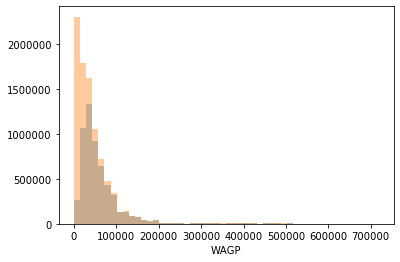

In [7]:
g = sns.distplot(PUS_start["WAGP"][(PUS_start["WAGP"] > 0) & (
    PUS_start["WKW"] < 4) & (PUS_start["WKHP"] >= 40)], kde=False)
g = sns.distplot(PUS_start["WAGP"][(PUS_start["WAGP"] > 0)], kde=False)

In [8]:
# define function to seperate people who've worked more than 40 weeks / year
def full_time_detect(df):
    # remove rows of people who work under 40 weeks in a year
    df = df.loc[df.WKW < 4].copy()
    # remove rows of people who work under 35 hours a week
    df = df.loc[df.WKHP >= 40].copy()
    # remove rows of people below 18 and above 70
    df = df.loc[df.AGEP >= 18].copy()
    df = df.loc[df.AGEP <= 70].copy()
    return df

In [9]:
ft_test = PUS_start.copy()
ft_test = full_time_detect(ft_test)
print(ft_test.shape)

(5846161, 10)


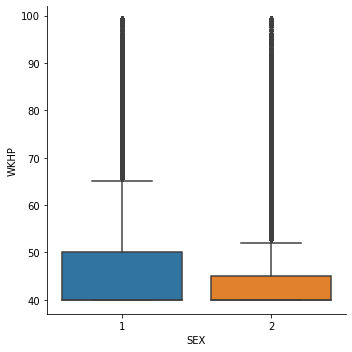

In [10]:
g = sns.catplot(y="WKHP", x="SEX", data=ft_test, kind="box")

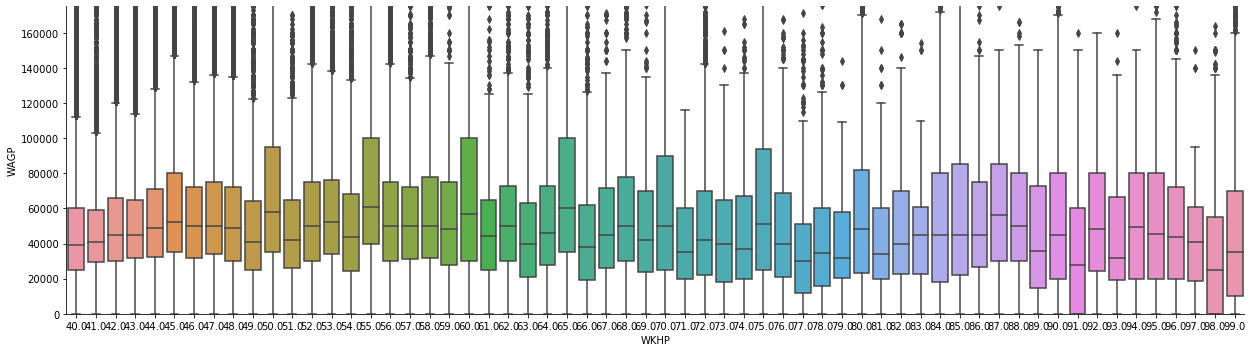

In [11]:
g = sns.catplot(y="WAGP", x="WKHP", data=ft_test, kind="box", aspect=3.5)
g.set(ylim=(0, 175000))

## 2.2. Outlier

Besides full-time workers in the US, outliers in the wage earned were excluded for this study. Quartile sectioning was used in determining significant outliers for the upper end, however the lower end was set at $12,500, the poverty level.

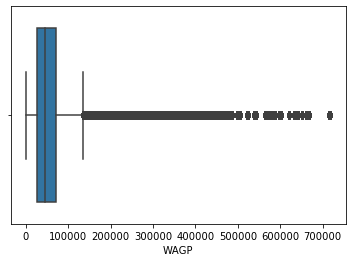

In [12]:
ax = sns.boxplot(x=ft_test["WAGP"])

In [13]:
test_wage_IQR = np.percentile(ft_test.WAGP, 75) - \
    np.percentile(ft_test.WAGP, 25)
test_wage_upper = np.percentile(ft_test.WAGP, 75) + test_wage_IQR*3
test_wage_lower = np.percentile(ft_test.WAGP, 25) - test_wage_IQR*3
print("Wage IQR: ", test_wage_IQR, " Upper: ",
      test_wage_upper, " Lower: ", test_wage_lower)

Wage IQR:  43000.0  Upper:  199000.0  Lower:  -102000.0


In [14]:
def outlier_wage(df):
    # remove rows of outlier upper wages and below poverty $
    wage_IQR = np.percentile(df.WAGP, 75) - np.percentile(df.WAGP, 25)
    wage_upper = np.percentile(df.WAGP, 75) + wage_IQR*3
    df = df.loc[df.WAGP >= 12500].copy()
    df = df.loc[df.WAGP <= wage_upper].copy()
    return df

In [15]:
outlier_test = ft_test.copy()
outlier_test = outlier_wage(outlier_test)
print(outlier_test.shape)

(5216628, 10)


# 3. Feature Transformation
## 3.1. Age Bins

As seen in the graph of wage vs age, its seen that there in a steady increase in wages from age 18 to 35 in which it levels out throughout the rest of the years. Therefore, capturing the trends was slightly difficult, so the binning tried to mimic the general trend of this observation. Also, while a further gradient in wages could be a achieved in the initial ages, the sample sizes were relatively small at those level and segmentation of the data would cause issues.
The binning maintained the general trend of the age gaps but show similar ranges for 3 and 4 which was assumed since the wages level out greatly throughout ages past 40. While it can be separated, there might be more relationships between other variables, so the ages were kept split for their large sample size as well.

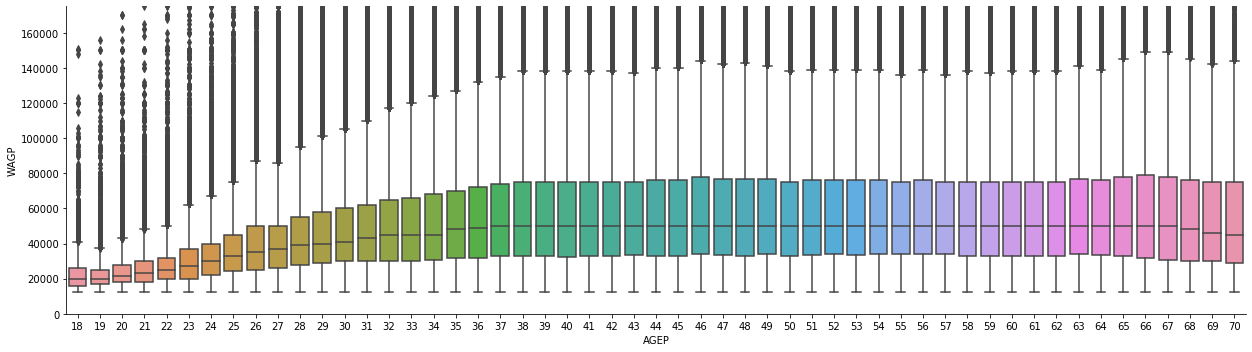

In [16]:
g = sns.catplot(y="WAGP", x="AGEP", data=outlier_test, kind="box", aspect=3.5)
g.set(ylim=(0, 175000))

In [17]:
def age_bins(df):
    df['AGEB'] = df['AGEP'].map(lambda y: 1 if y <= 25  # 18-25
                                else 2 if y <= 35  # 26-35
                                else 3 if y <= 45  # 36-45
                                else 4 if y <= 65  # 46-65
                                else 3 if y <= 70  # 60-70
                                else 6)  # +70
    return df

In [18]:
age_test = outlier_test.copy()
age_test.sort_values(by=['AGEP'], ascending=True, inplace=True)

In [19]:
age_bins(age_test)
print("Age :", age_test.AGEB.unique())

Age : [1 2 3 4]


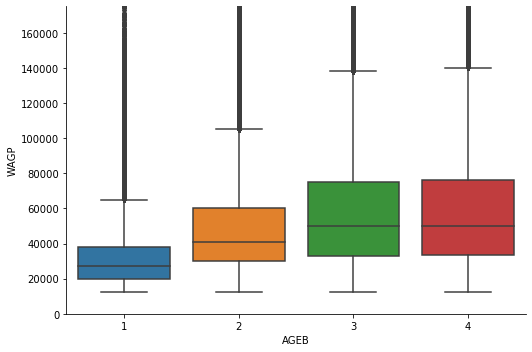

In [20]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test, kind="box", aspect=1.5)
g.set(ylim=(0, 175000))

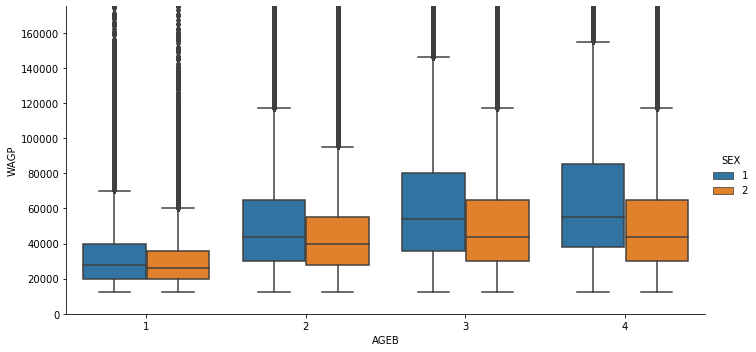

In [21]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test,
                kind="box", aspect=2, hue="SEX")
g.set(ylim=(0, 175000))

In [22]:
age_test['AGEB'].value_counts()

4    2326233
3    1345201
2    1158316
1     386878
Name: AGEB, dtype: int64

## 3.2. Education Categorization

The education levels were separated out through numerical values coded to separate values. All values 15 and under link to no schooling, preschool, and grades k-12, 16 and 17 are those finishing high school or getting a GED, values above are varying levels of college and graduate school (further details below and in appendix).

Overall, it's observed that the greater the level of education led to greater wage. For those who dropped out of high school there is no specific trends with when the drop out of school, for high school graduates have similar values, and finally those with some college or an associate degree were similar. Higher education showed gradually higher wages.

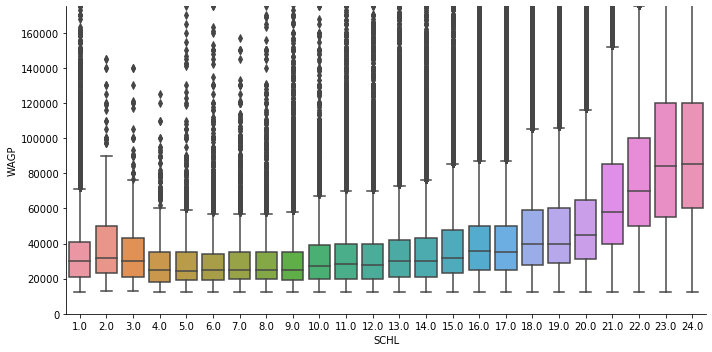

In [23]:
g = sns.catplot(y="WAGP", x="SCHL", data=age_test, kind="box", aspect=2)
g.set(ylim=(0, 175000))

In [24]:
def edu_split(df):
    # split into degrees
    df['EDU'] = df['SCHL'].map(lambda y: 1 if y <= 15  # didn't finish HS
                               else 1 if y <= 17  # HS degree
                               else 2 if y <= 19  # some college
                               else 2 if y == 20  # AS
                               else 3 if y == 21  # BS
                               else 4 if y == 22  # MS
                               else 5 if y <= 24  # GS
                               else 7)
    return df

In [25]:
edu_test = age_test.copy()
edu_test = edu_split(edu_test)
print("Edu :", edu_test.EDU.unique())

Edu : [1 2 3 4 5]


In [26]:
edu_sort = edu_test.groupby('EDU').median(
).sort_values(by=['WAGP']).reset_index()
edu_list = edu_sort['EDU'].tolist()

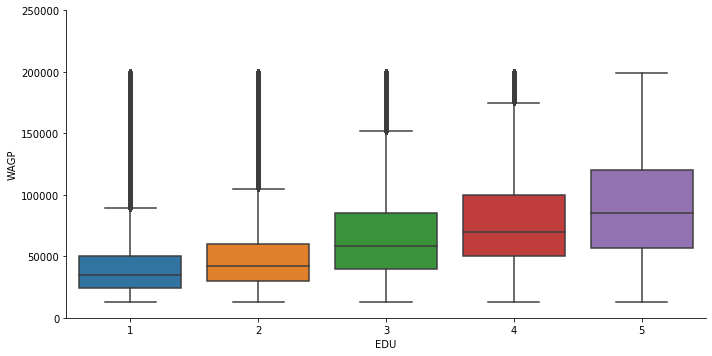

In [27]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test,
                kind="box", aspect=2, order=edu_list)
g.set(ylim=(0, 250000))

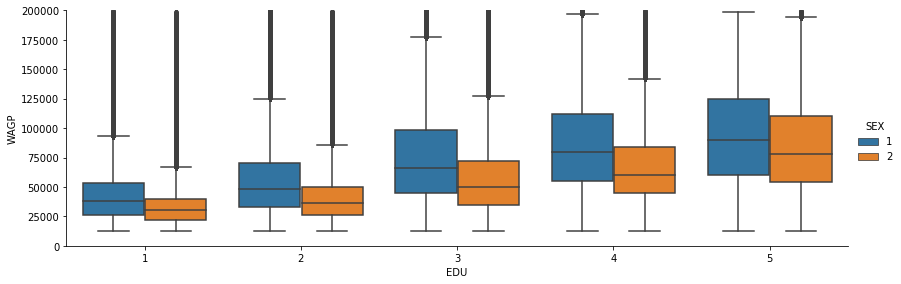

In [28]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test, kind="box",
                height=4, aspect=3, hue="SEX", order=edu_list)
g.set(ylim=(0, 200000))

In [29]:
edu_test['EDU'].value_counts()

2    1638229
1    1611000
3    1230774
4     539844
5     196781
Name: EDU, dtype: int64

## 3.3. Occupation Grouping

The occupations are sorted by industry and standardized across all years. They are as follows:
- 0010-0960: Management, Business, and Financial Occupations
- 1005-1980: Computer, Engineering, and Science Occupations
- 2001-2970: Education, Legal, Community Service, Arts, and Media Occupations
- 3000-3550: Healthcare Practitioners and Technical Occupations
- 3601-4655: Service Occupations
- 4700-5940: Sales and Office Occupations
- 6005-7640: Natural Resources, Construction, and Maintenance Occupations
- 7700-8990: Production Occupations
- 9005-9760: Transportation and Material Moving Occupations
- 9800-9830: Military Specific Occupations

When observing each industry, there were grouped according to their similarity in wages and how to split their populations. Overall, each of the occupations a wide range of wages that could be affected by other variables such as those who go into business or sciences generally have a higher degree and therefore make more. While these observations are difficult to observe, the general splitting was used to maintain the trend observed.

The grouping is as followed below. Overall, the similar values between each industry was maintained through the grouping of each industry. As observed with all variables before, gender trends between each value show woman are paid less then man.

In [30]:
def int_occ_split(df):
    # split into occupational industries
    df['JOB'] = df['OCCP'].map(lambda y: "Business" if y <= 960
                               else "Science" if y <= 1980
                               else "Arts" if y <= 2970
                               else "Healthcare" if y <= 3550
                               else "Service" if y <= 4655
                               else "Sales" if y <= 5940
                               else "Maintenance" if y <= 7640
                               else "Production" if y <= 8990
                               else "Transportation" if y <= 9760
                               else "Military" if y <= 9830
                               else "UN")
    return df

In [31]:
int_occ_test = edu_test.copy()
int_occ_test = int_occ_split(int_occ_test)
print("Occ :", int_occ_test.JOB.unique())

Occ : ['Maintenance' 'Service' 'Business' 'Sales' 'Science' 'Production'
 'Transportation' 'Healthcare' 'Arts' 'Military']


In [32]:
int_occ_sort = int_occ_test.groupby(
    'JOB').median().sort_values(by=['WAGP']).reset_index()
int_occ_list = int_occ_sort['JOB'].tolist()

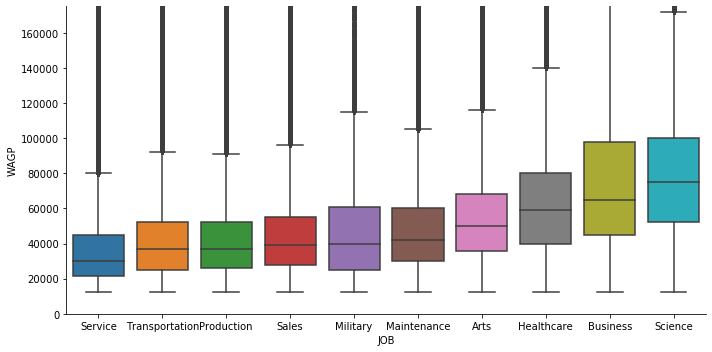

In [33]:
g = sns.catplot(y="WAGP", x="JOB", data=int_occ_test,
                kind="box", aspect=2, order=int_occ_list)
g.set(ylim=(0, 175000))

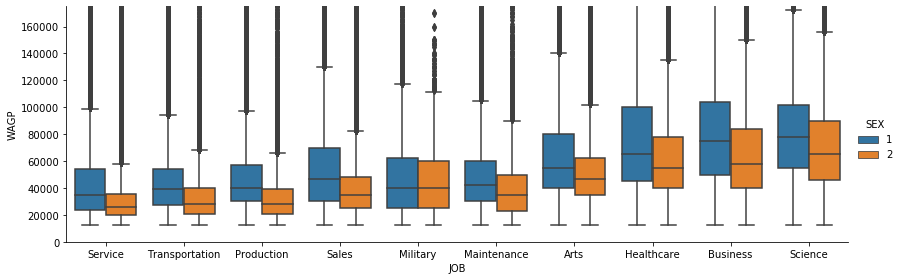

In [34]:
g = sns.catplot(y="WAGP", x="JOB", data=int_occ_test, kind="box",
                height=4, aspect=3, hue="SEX", order=int_occ_list)
g.set(ylim=(0, 175000))

In [35]:
int_occ_test['JOB'].value_counts()

Sales             1159118
Business           966283
Arts               576643
Service            575590
Maintenance        525319
Science            395275
Production         386662
Transportation     329590
Healthcare         274677
Military            27471
Name: JOB, dtype: int64

In [36]:
def occ_split(df):
    # split into occupational industries
    df['JOB'] = df['OCCP'].map(lambda y: 4 if y <= 960  # Business
                               else 4 if y <= 1980  # Science
                               else 3 if y <= 2970  # Arts
                               else 3 if y <= 3550  # Healthcare
                               else 1 if y <= 4655  # Service
                               else 2 if y <= 5940  # Sales
                               else 2 if y <= 7640  # Maintenance
                               else 1 if y <= 8990  # Production
                               else 1 if y <= 9760  # Transportation
                               else 2 if y <= 9830  # Military
                               else 6)  # Undefined
    return df

In [37]:
occ_test = edu_test.copy()
occ_test = occ_split(occ_test)
print("Occ :", occ_test.JOB.unique())

Occ : [2 1 4 3]


In [38]:
occ_test['JOB'].value_counts()

2    1711908
4    1361558
1    1291842
3     851320
Name: JOB, dtype: int64

In [39]:
occ_sort = occ_test.groupby('JOB').median(
).sort_values(by=['WAGP']).reset_index()
occ_list = occ_sort['JOB'].tolist()

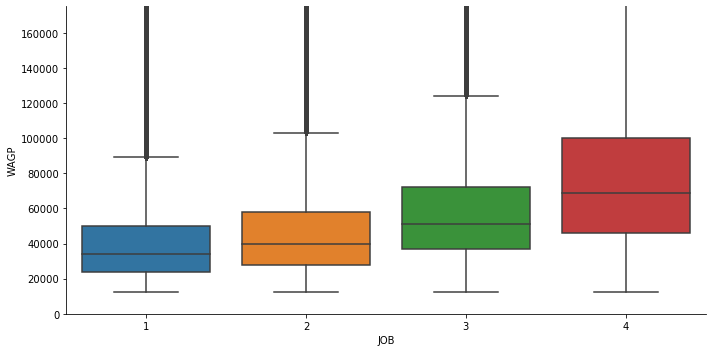

In [40]:
g = sns.catplot(y="WAGP", x="JOB", data=occ_test,
                kind="box", aspect=2, order=occ_list)
g.set(ylim=(0, 175000))

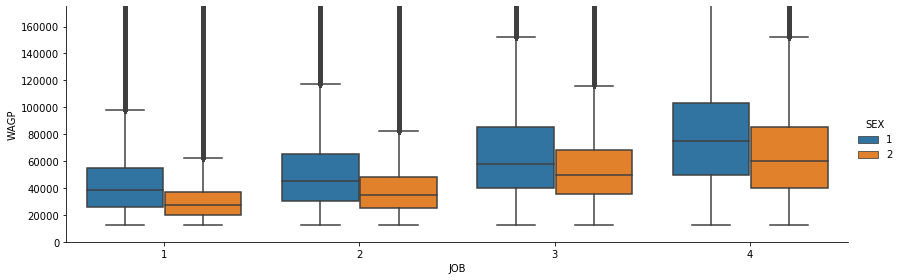

In [41]:
g = sns.catplot(y="WAGP", x="JOB", data=occ_test, kind="box",
                height=4, aspect=3, hue="SEX", order=occ_list)
g.set(ylim=(0, 175000))

## 3.4. State Observations
There was an interesting variable within the data stating the state which the person worked in. While it would have been simple if there was a trend in regions, but as observed, there is only a slight difference between each state due to the variation between each state. It still isn't clear what each stat's wage is, and it's difficult to extract the details needed to separate out each value.

Therefore, the general regions were used for each value, split between Northeast/Outlying Regions, West, Midwest, and South. While not too distinct, this separation should be sufficient.

In [42]:
int_state_sort = occ_test.groupby('POWSP').median().reset_index()
int_state_sort['reg_code'] = ['3', '4', '4', '3', '4', '4', '1', '3', '3', '3',
                              '3', '4', '4', '2', '2', '2', '2', '3', '3', '1',
                              '3', '1', '2', '2', '3', '2', '4', '2', '4', '1',
                              '1', '4', '1', '3', '2', '2', '3', '4', '1', '1',
                              '3', '2', '3', '3', '4', '1', '3', '4', '3', '2',
                              '4', '5', '5', '5', '5', '5', '5', '5', '5','5']
int_state_sort = int_state_sort.sort_values(by=['WAGP'])
int_state_list = int_state_sort['POWSP'].tolist()

In [43]:
reg_sort = int_state_sort.sort_values(by=['reg_code'])
reg_list = reg_sort['POWSP'].tolist()

In [44]:
ST_list = reg_sort['ST'].tolist()
print(ST_list)

[50, 9, 25, 34, 36, 44, 42, 23, 33, 38, 55, 39, 18, 20, 27, 26, 29, 31, 46, 17, 19, 10, 48, 51, 24, 24, 28, 45, 5, 22, 40, 12, 21, 54, 37, 1, 47, 13, 35, 30, 53, 16, 4, 2, 8, 56, 41, 49, 15, 32, 6, 25, 26, 26, 34, 21, 48, 26, 32, 27]


In [45]:
print(reg_list)

[50.0, 9.0, 25.0, 34.0, 36.0, 44.0, 42.0, 23.0, 33.0, 38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0, 10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0, 35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0, 166.0, 399.0, 555.0, 72.0, 251.0, 303.0, 213.0, 254.0, 301.0]


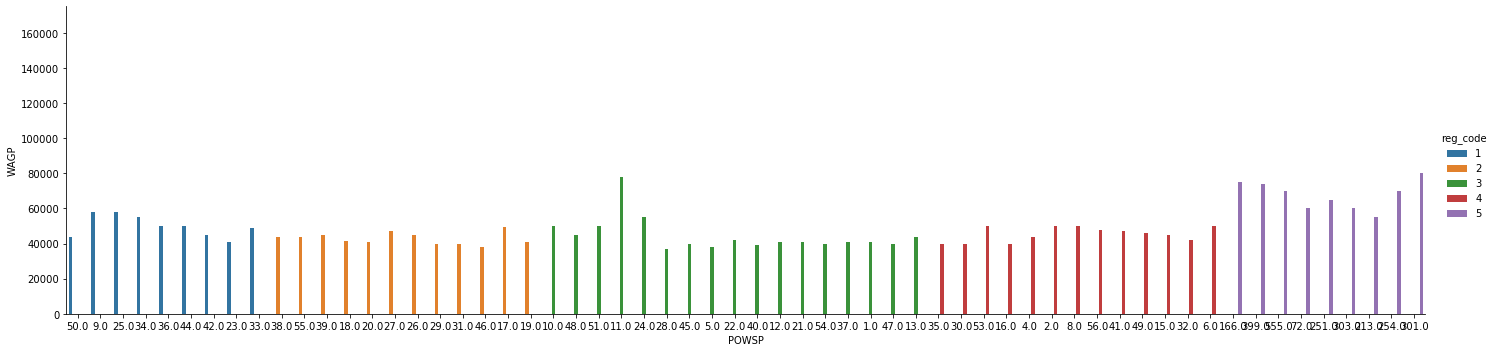

In [46]:
g = sns.catplot(y="WAGP", x="POWSP", hue='reg_code',
                data=reg_sort, kind="bar", aspect=4, order=reg_list)
g.set(ylim=(0, 175000))

In [47]:
int_state_sort.groupby('reg_code').median()

POWSP  ST  AGEP  SCHL  SEX     WAGP  WKHP  WKW    OCCP  RAC1P  AGEB  \
reg_code                                                                        
1          34.0  34    45  20.0    1  50000.0  40.0  1.0  3930.0      1     3   
2          28.0  28    45  19.0    1  42700.0  40.0  1.0  4700.0      1     3   
3          24.0  24    44  19.0    1  41000.0  40.0  1.0  4520.0      1     3   
4          30.0  30    44  19.0    1  46000.0  40.0  1.0  4220.0      1     3   
5         254.0  26    46  20.0    1  70000.0  45.0  1.0  2640.0      1     4   

          EDU  JOB  
reg_code            
1           2    2  
2           2    2  
3           2    2  
4           2    2  
5           2    3

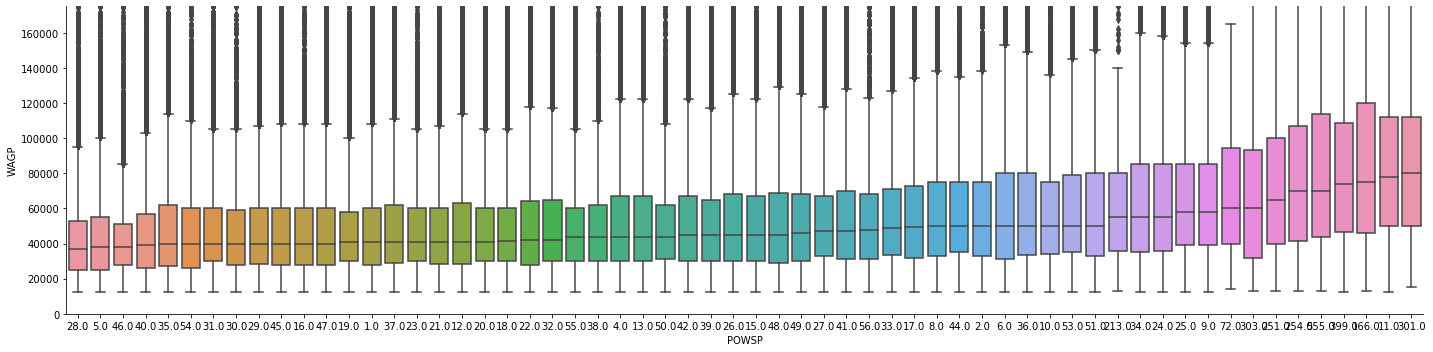

In [48]:
g = sns.catplot(y="WAGP", x="POWSP", data=occ_test,
                kind="box", aspect=4, order=int_state_list)
g.set(ylim=(0, 175000))

In [49]:
print(int_state_list)

[28.0, 5.0, 46.0, 40.0, 35.0, 54.0, 31.0, 30.0, 29.0, 45.0, 16.0, 47.0, 19.0, 1.0, 37.0, 23.0, 21.0, 12.0, 20.0, 18.0, 22.0, 32.0, 55.0, 38.0, 4.0, 13.0, 50.0, 42.0, 39.0, 26.0, 15.0, 48.0, 49.0, 27.0, 41.0, 56.0, 33.0, 17.0, 8.0, 44.0, 2.0, 6.0, 36.0, 10.0, 53.0, 51.0, 213.0, 34.0, 24.0, 25.0, 9.0, 72.0, 303.0, 251.0, 254.0, 555.0, 399.0, 166.0, 11.0, 301.0]


In [50]:
def state_split(df):
    # split into higher paying regions (4 = Northeast/Outlying Regions, 3= West Coast, 2 = Midwest, 1 = South)
    df['STSP'] = df['POWSP'].map(lambda y: 4 if y in [50, 25.0, 9.0, 34.0, 36.0, 42.0, 44.0, 23.0, 33.0, 303.0, 166.0, 72.0, 251.0, 399.0, 301.0, 555.0, 254.0]
                                  else 3 if y in [35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0]
                                  else 2 if y in [38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0]
                                  else 1 if y in [10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0]
                                 else 5)
    test = df.loc[df['STSP'] == 5].copy()
    df = df.loc[df['STSP'] != 5].copy()
    test['STSP'] = test['ST'].map(lambda y: 4 if y in [50, 25.0, 9.0, 34.0, 36.0, 42.0, 44.0, 23.0, 33.0, 303.0, 166.0, 72.0, 251.0, 399.0, 301.0, 555.0, 254.0]
                                  else 3 if y in [35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0]
                                  else 2 if y in [38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0]
                                  else 1 if y in [10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0]
                                  else 10)
    df = pd.concat([df, test])
    return df

In [51]:
state_test = occ_test.copy()
state_test = state_split(state_test)
print("State :", state_test.STSP.unique())
state_test['STSP'].value_counts()

State : [3 2 1 4]


1    1960356
3    1177718
2    1159869
4     918685
Name: STSP, dtype: int64

In [52]:
state_sort = state_test.groupby(
    'STSP').median().sort_values(by=['WAGP']).reset_index()
state_list = state_sort['STSP'].tolist()

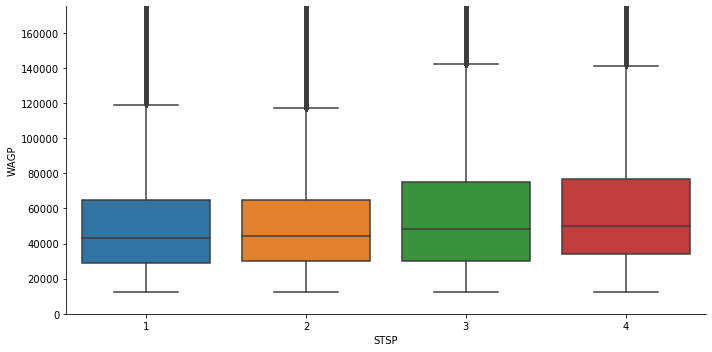

In [53]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test,
                kind="box", aspect=2, order=state_list)
g.set(ylim=(0, 175000))

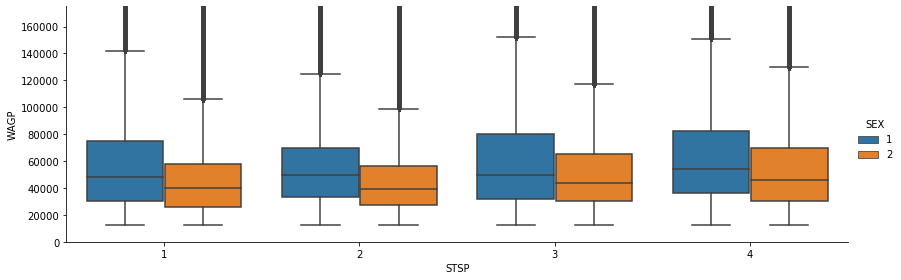

In [54]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test, kind="box",
                height=4, aspect=3, hue="SEX", order=state_list)
g.set(ylim=(0, 175000))

## 3.5. Race

Race was a difficult subject to separate amongst values due to the majority of those sampled as of white decent. The general split was between Whites, Asians, Blacks. and Others.

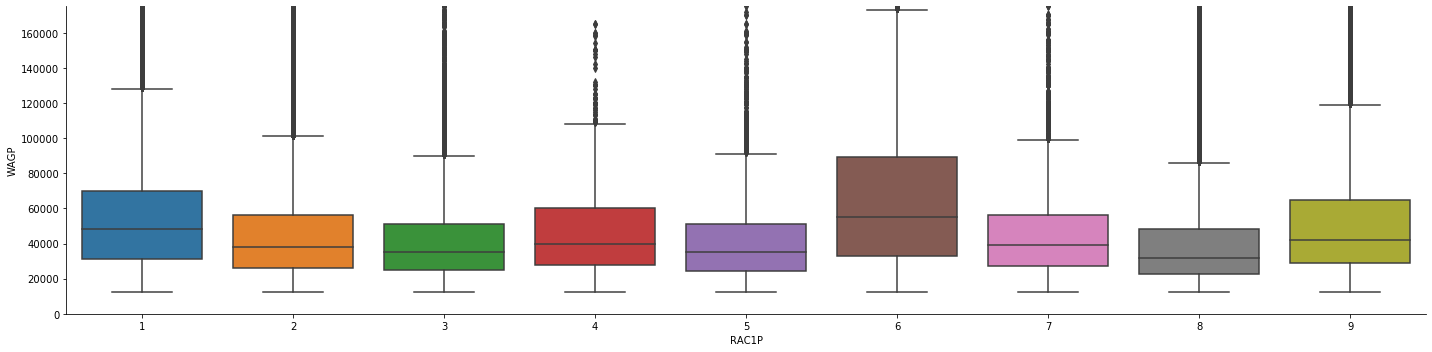

In [55]:
g = sns.catplot(y="WAGP", x="RAC1P", data=state_test, kind="box", aspect=4)
g.set(ylim=(0, 175000))

In [56]:
state_test['RAC1P'].value_counts()

1    4130212
2     468840
6     283418
8     184614
9      98429
3      34664
7       8488
5       6502
4       1461
Name: RAC1P, dtype: int64

In [57]:
def int_race_split(df):
    # split into occupational industries
    df['RACE'] = df['RAC1P'].map(lambda y: "WHT" if y == 1  # white
                                 else "BLK" if y == 2  # black
                                 else "NTV" if y <= 5  # native
                                 else "ASN" if y == 6  # asian
                                 else "NTV" if y == 7  # native
                                 else "MIX" if y <= 9  # other
                                 else 4)

    return df

In [58]:
int_race_test = state_test.copy()
int_race_test = int_race_split(int_race_test)
print("RACE :", int_race_test.RACE.unique())

RACE : ['WHT' 'NTV' 'MIX' 'ASN' 'BLK']


In [59]:
int_race_test['RACE'].value_counts()

WHT    4130212
BLK     468840
ASN     283418
MIX     283043
NTV      51115
Name: RACE, dtype: int64

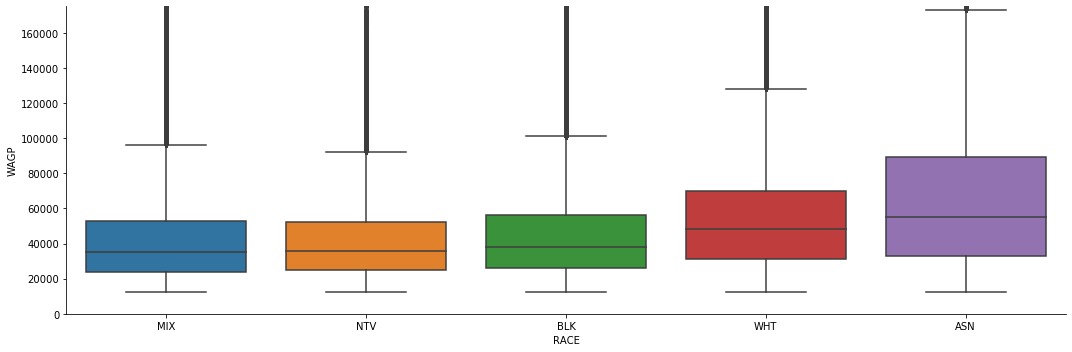

In [60]:
int_race_sort = int_race_test.groupby(
    'RACE').median().sort_values(by=['WAGP']).reset_index()
int_race_list = int_race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=int_race_test,
                kind="box", aspect=3, order=int_race_list)
g.set(ylim=(0, 175000))

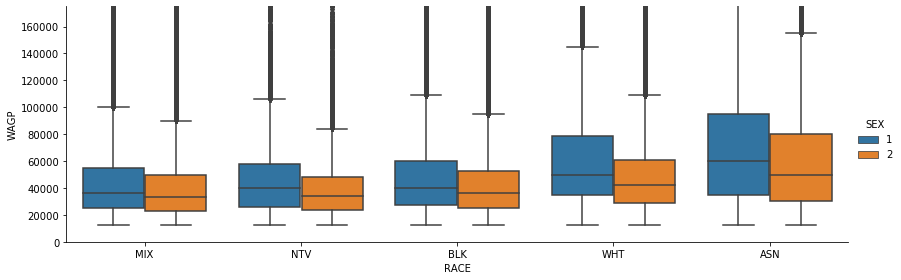

In [61]:
g = sns.catplot(y="WAGP", x="RACE", data=int_race_test, kind="box",
                height=4, aspect=3, hue="SEX", order =int_race_list)
g.set(ylim=(0, 175000))

In [62]:
def race_split(df):
    # split into occupational industries
    df['RACE'] = df['RAC1P'].map(lambda y: 2 if y == 1  # white
                                 else 1 if y == 2  # black
                                 else 1 if y <= 5  # native
                                 else 3 if y == 6  # asian
                                 else 1 if y == 7  # native
                                 else 1 if y <= 9  # other
                                 else 4)

    return df

In [63]:
race_test = state_test.copy()
race_test = race_split(race_test)
print("RACE :", race_test.RACE.unique())

RACE : [2 1 3]


In [64]:
race_test['RACE'].value_counts()

2    4130212
1     802998
3     283418
Name: RACE, dtype: int64

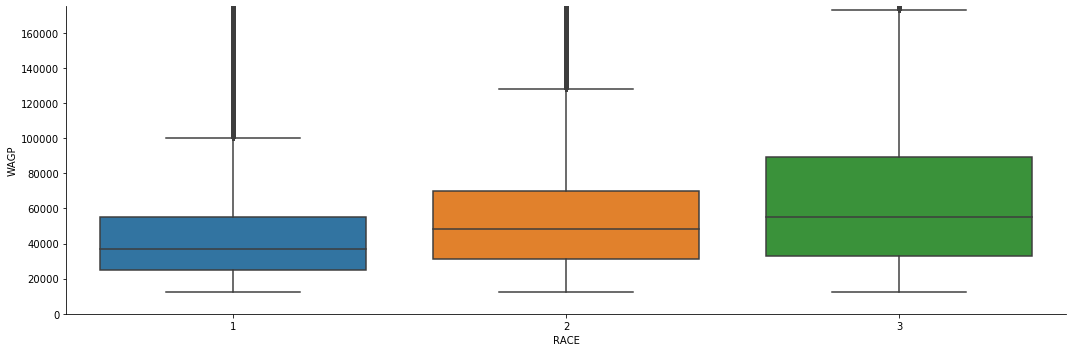

In [65]:
race_sort = race_test.groupby('RACE').median(
).sort_values(by=['WAGP']).reset_index()
race_list = race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=race_test,
                kind="box", aspect=3, order=race_list)
g.set(ylim=(0, 175000))

# 4. Dataframe Management
## 4.1. Remove Columns
With the data and feature mostly processed for all the values, the excess columns are removed to clean up the dataframes. The main columns to keep were those axis aimed to align upon, sex, age, education, race, region, and industry.

In [66]:
race_test.columns

Index(['ST', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'OCCP', 'POWSP',
       'RAC1P', 'AGEB', 'EDU', 'JOB', 'STSP', 'RACE'],
      dtype='object')

In [67]:
race_test.describe(include='all')

ST          AGEP          SCHL           SEX          WAGP  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   2.792770e+01  4.367315e+01  1.875502e+01  1.423788e+00  5.470252e+04   
std    1.603593e+01  1.221741e+01  3.174406e+00  4.941576e-01  3.347824e+04   
min    1.000000e+00  1.800000e+01  1.000000e+00  1.000000e+00  1.250000e+04   
25%    1.200000e+01  3.300000e+01  1.600000e+01  1.000000e+00  3.000000e+04   
50%    2.700000e+01  4.400000e+01  1.900000e+01  1.000000e+00  4.500000e+04   
75%    4.200000e+01  5.400000e+01  2.100000e+01  2.000000e+00  7.000000e+04   
max    5.600000e+01  7.000000e+01  2.400000e+01  2.000000e+00  1.990000e+05   

               WKHP           WKW          OCCP         POWSP         RAC1P  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.053287e+06  5.216628e+06   
mean   4.449304e+01  1.106981e+00  4.127022e+03  2.808633e+01  1.789074e+00   
std    7.893772e+00  4.297612e-01  2.790060e+03  1.803378e+01  1.968440e+00   
min    4.000000e+01  1.000000e+00  1.000000e+01  1.000000e+00  1.000000e+00   
25%    4.000000e+01  1.000000e+00  1.610000e+03  1.200000e+01  1.000000e+00   
50%    4.000000e+01  1.000000e+00  4.220000e+03  2.700000e+01  1.000000e+00   
75%    4.800000e+01  1.000000e+00  5.860000e+03  4.200000e+01  1.000000e+00   
max    9.900000e+01  3.000000e+00  9.830000e+03  5.550000e+02  9.000000e+00   

               AGEB           EDU           JOB          STSP          RACE  
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  
mean   3.075559e+00  2.247249e+00  2.437561e+00  2.202187e+00  1.900399e+00  
std    9.792398e-01  1.112232e+00  1.124005e+00  1.124767e+00  4.453537e-01  
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
25%    2.000000e+00  1.000000e+00  2.000000e+00  1.000000e+00  2.000000e+00  
50%    3.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  
75%    4.000000e+00  3.000000e+00  4.000000e+00  3.000000e+00  2.000000e+00  
max    4.000000e+00  5.000000e+00  4.000000e+00  4.000000e+00  3.000000e+00

In [68]:
def remove_col(df):
    remove_cols = ['SCHL', 'WKHP', 'WKW',
                   'OCCP', 'POWSP', 'RAC1P', 'AGEP', 'ST']
    df = df.drop(remove_cols, axis=1)
    return df

In [69]:
remove_test = race_test.copy()
remove_test = remove_col(remove_test)
remove_test.describe(include='all')

SEX          WAGP          AGEB           EDU           JOB  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   1.423788e+00  5.470252e+04  3.075559e+00  2.247249e+00  2.437561e+00   
std    4.941576e-01  3.347824e+04  9.792398e-01  1.112232e+00  1.124005e+00   
min    1.000000e+00  1.250000e+04  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.000000e+00  3.000000e+04  2.000000e+00  1.000000e+00  2.000000e+00   
50%    1.000000e+00  4.500000e+04  3.000000e+00  2.000000e+00  2.000000e+00   
75%    2.000000e+00  7.000000e+04  4.000000e+00  3.000000e+00  4.000000e+00   
max    2.000000e+00  1.990000e+05  4.000000e+00  5.000000e+00  4.000000e+00   

               STSP          RACE  
count  5.216628e+06  5.216628e+06  
mean   2.202187e+00  1.900399e+00  
std    1.124767e+00  4.453537e-01  
min    1.000000e+00  1.000000e+00  
25%    1.000000e+00  2.000000e+00  
50%    2.000000e+00  2.000000e+00  
75%    3.000000e+00  2.000000e+00  
max    4.000000e+00  3.000000e+00

## 4.2. OHE Columns
While it was ultimately decided that using OHE was not needed for the purposes of this model, but this section is showing how this would be achieved and implemented into the workflow. It works for the purposes of OHE each column and can be easily implemented.

In [70]:
def OHE_cat(df):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    cat_col = [i for i in df.columns.tolist() if i not in ['WAGP']]
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df[cat_col]))
    OH_cols_train.index = df.index
    df = pd.concat([df, OH_cols_train], axis=1)
    df.drop(cat_col, axis=1, inplace=True)
    return df

In [71]:
OHE_test = remove_test.copy()
OHE_test = OHE_cat(OHE_test)
OHE_test.describe(include='all')

WAGP             0             1             2             3  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   5.470252e+04  5.762124e-01  4.237876e-01  7.416247e-02  2.220431e-01   
std    3.347824e+04  4.941576e-01  4.941576e-01  2.620351e-01  4.156200e-01   
min    1.250000e+04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.000000e+04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    4.500000e+04  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    7.000000e+04  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
max    1.990000e+05  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  4             5             6             7             8  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   2.578679e-01  4.459266e-01  3.088202e-01  3.140398e-01  2.359329e-01   
std    4.374610e-01  4.970675e-01  4.620068e-01  4.641324e-01  4.245805e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

       ...            12            13            14            15  \
count  ...  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   ...  3.281637e-01  1.631935e-01  2.610035e-01  3.757899e-01   
std    ...  4.695448e-01  3.695422e-01  4.391818e-01  4.843262e-01   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
max    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 16            17            18            19            20  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   2.223408e-01  2.257623e-01  1.761071e-01  1.539305e-01  7.917398e-01   
std    4.158189e-01  4.180834e-01  3.809113e-01  3.608821e-01  4.060639e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 21  
count  5.216628e+06  
mean   5.432973e-02  
std    2.266672e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 23 columns]

In [72]:
OHE_names = remove_test.copy()
OH_encoder2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_col2 = [i for i in OHE_names.columns.tolist() if i not in ['WAGP']]
OH_cols_train2 = pd.DataFrame(OH_encoder2.fit_transform(OHE_names[cat_col2]))

OHEcol2 = OH_encoder2.get_feature_names(cat_col2)
OHEcols2 = pd.DataFrame()
OHEcols2['Features'] = OHEcol2

OHEcols2

Features
0     SEX_1
1     SEX_2
2    AGEB_1
3    AGEB_2
4    AGEB_3
5    AGEB_4
6     EDU_1
7     EDU_2
8     EDU_3
9     EDU_4
10    EDU_5
11    JOB_1
12    JOB_2
13    JOB_3
14    JOB_4
15   STSP_1
16   STSP_2
17   STSP_3
18   STSP_4
19   RACE_1
20   RACE_2
21   RACE_3

# 5. Preprocessing Pipeline
Combining all the other steps, a pipeline was formed to easily test out a dataframe and transform it to the needs. Given its modular nature it's simple to change how each individual section acts without disturbing the whole notebook. Below outlines the data selection, feature transformation, and dataframe management sections.

In the graphs below, jobs, education, and age were compared against one another to see how wages correlates with wages and how much each feature affects one another. It’s observed that each of the values have a high correlation with wage and seems to be independently increasing wages, but also dependent on one another for the extent in which the wage varies.

In [73]:
def pp_pipeline(df):
    df = (df
          .pipe(full_time_detect)
          .pipe(outlier_wage)
          .pipe(age_bins)
          .pipe(edu_split)
          .pipe(occ_split)
          .pipe(state_split)
          .pipe(race_split)
          .pipe(remove_col)
          #.pipe(OHE_cat)
          )
    return df

In [74]:
start_time = time.time()
pp_test = PUS_start.copy()
pp_test = pp_pipeline(pp_test)
print(" %s min" % round(((time.time() - start_time)/60), 2))
pp_test.describe(include='all')

 0.61 min


SEX          WAGP          AGEB           EDU           JOB  \
count  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06  5.216628e+06   
mean   1.423788e+00  5.470252e+04  3.075559e+00  2.247249e+00  2.437561e+00   
std    4.941576e-01  3.347824e+04  9.792398e-01  1.112232e+00  1.124005e+00   
min    1.000000e+00  1.250000e+04  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.000000e+00  3.000000e+04  2.000000e+00  1.000000e+00  2.000000e+00   
50%    1.000000e+00  4.500000e+04  3.000000e+00  2.000000e+00  2.000000e+00   
75%    2.000000e+00  7.000000e+04  4.000000e+00  3.000000e+00  4.000000e+00   
max    2.000000e+00  1.990000e+05  4.000000e+00  5.000000e+00  4.000000e+00   

               STSP          RACE  
count  5.216628e+06  5.216628e+06  
mean   2.202187e+00  1.900399e+00  
std    1.124767e+00  4.453537e-01  
min    1.000000e+00  1.000000e+00  
25%    1.000000e+00  2.000000e+00  
50%    2.000000e+00  2.000000e+00  
75%    3.000000e+00  2.000000e+00  
max    4.000000e+00  3.000000e+00

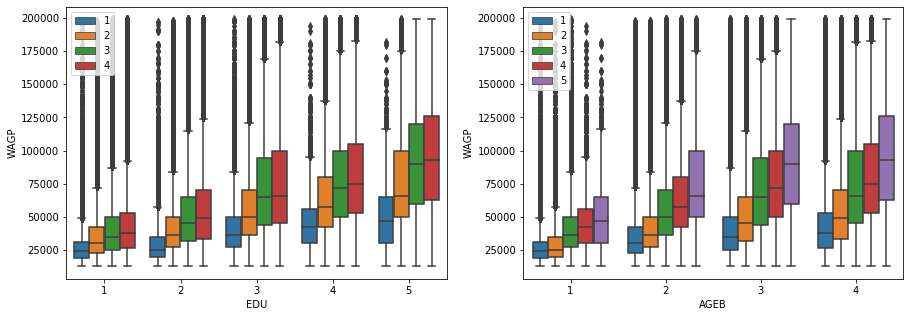

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.catplot(y="WAGP", x = 'EDU',hue = 'AGEB',data=pp_test,kind="box", ax=ax[0])
ax[0].legend(loc="upper left")
sns.catplot(y="WAGP", x = 'AGEB',hue = 'EDU',data=pp_test,kind="box", ax=ax[1])
ax[1].legend(loc="upper left")
plt.close(2)
plt.close(3)

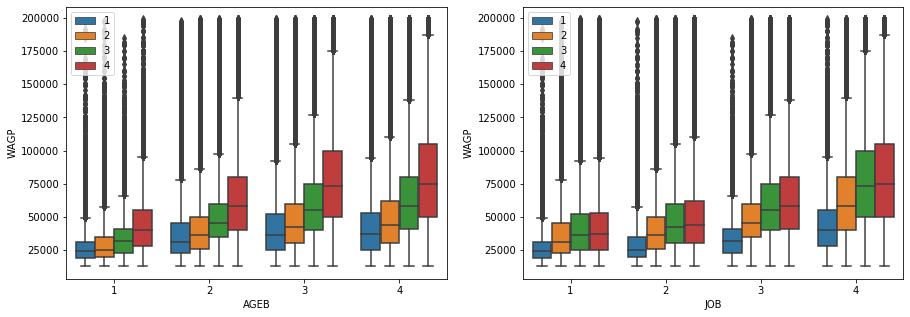

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.catplot(y="WAGP", x = 'AGEB',hue = 'JOB',data=pp_test,kind="box",legend_out=True,ax=ax[0])
ax[0].legend(loc="upper left")
sns.catplot(y="WAGP", x = 'JOB',hue = 'AGEB',data=pp_test,kind="box",legend_out=True,ax=ax[1])
ax[1].legend(loc="upper left")
plt.close(2)
plt.close(3)

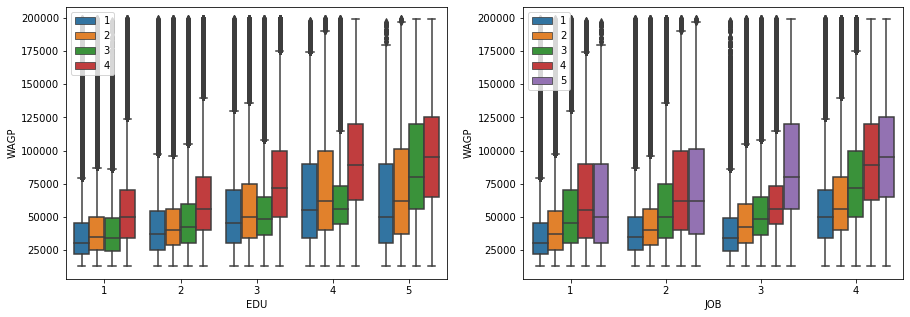

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.catplot(y="WAGP", x = 'EDU',hue = 'JOB',data=pp_test,kind="box",legend_out=True,ax=ax[0])
ax[0].legend(loc="upper left")
sns.catplot(y="WAGP", x = 'JOB',hue = 'EDU',data=pp_test,kind="box",legend_out=True,ax=ax[1])
ax[1].legend(loc="upper left")
plt.close(2)
plt.close(3)

# 6. Modeling
## 6.1. Random Forest
Below outlines how each the data was modeled. Since the modeling was used to be a comparative value, it wasn't necessarily finetuned for each parameter. Random forest regressor was used as a standard. Given how large the datafile is, it's difficult to fully fit and predict the dataset fully. Luckily, having more data isn't a problem.

The dataset was split accordingly to be able to tune some parameter and ultimately fit to a random forest regressor.

In [121]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel

In [122]:
cv_split = pp_test.copy()
cv_split.shape
param_split = cv_split.sample(frac=0.02)
param_split.shape

(104333, 7)

In [123]:
param_y = param_split['WAGP']
param_x = param_split.drop(['WAGP'], axis=1)

In [124]:
kfold = StratifiedKFold(n_splits=3)

RFR = RandomForestRegressor()
rfr_param_grid = {'n_estimators': [50, 100],
                  'min_samples_split': [5, 10],
                  'min_samples_leaf': [10, 20]}

gsRFR = GridSearchCV(RFR, param_grid=rfr_param_grid, cv=kfold,
                     scoring="neg_mean_absolute_error", verbose=1, n_jobs=4)

gsRFR.fit(param_x, param_y)

RFR_best = gsRFR.best_estimator_

gsRFR.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   47.6s finished


-19499.014408436637

In [125]:
RFR_best

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [126]:
fit_split = cv_split.sample(frac=0.3)
fit_split.shape

(1564988, 7)

In [127]:
y_full = fit_split['WAGP']
X_full = fit_split.drop(['WAGP'], axis=1)

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, random_state=0)

In [129]:
start_time = time.time()
RFR_best.fit(X_train, y_train)
pred_valid = RFR_best.predict(X_valid)
print("MAE : ", mean_absolute_error(y_valid, pred_valid))
print(" %s min" % round(((time.time() - start_time)/60), 2))

MAE :  19474.896528196645
 3.34 min


## 6.2. Feature Selection
Overall, it's observed that education, occupational industry, and age are the main indicators or wage with sex follow up behind (region and race had minimal impact, but could have more value is more details were provided, or if the model was fit with an artificially higher ratio of minority races or if the states were separated more finely)

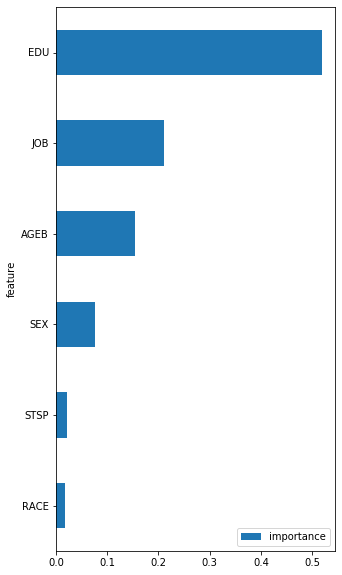

In [130]:
features = pd.DataFrame()
features['feature'] = X_full.columns
features['importance'] = RFR_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(5, 10))

# 7. Analysis
## 7.1. Scoring Rational
Below is the function to score a dataset for an individual year. It's extremely difficult to capture the total wage gap of the entire united states since each region, industry, education level has a different level of variance between men and woman. Therefore, to capture this information all in a single number is intimidating and difficult.

The core methodology was that (1) the score should encapsulate the entire US population so it should be weighted, (2) maintain sex separation between feature so male vs. female dominated industries don't have a bias, and (3) compare the values between true wages and predicted wages to determine if there's any significant differences.

Function commented below:

In [143]:
def get_score(df):
    y_5 = df['WAGP']
    x_5 = df.drop(['WAGP'], axis=1)
#predicted values given fit
    preds_test = RFR_best.predict(x_5)
    output = pd.DataFrame(
        {'Index': x_5.index, 'WAG_pred': preds_test}).set_index('Index')
    result = pd.concat([output, df], axis=1, sort=False)
    
#split into male and female
    m_output = result[result['SEX'] == 1]
    f_output = result[result['SEX'] == 2]
    
#grouping data by feature
    m_g = m_output.groupby(['SEX', 'EDU', 'JOB', 'STSP', 'RACE', 'AGEB'], as_index=False).agg(
        {'WAG_pred': ['count', 'mean'], 'WAGP': ['count', 'mean', 'median','std']})
    m_g.columns = m_g.columns.map('_'.join).str.strip('_')

    f_g = f_output.groupby(['SEX', 'EDU', 'JOB', 'STSP', 'RACE', 'AGEB'], as_index=False).agg(
        {'WAG_pred': ['count', 'mean'], 'WAGP': ['count', 'mean', 'median','std']})
    f_g.columns = f_g.columns.map('_'.join).str.strip('_')
    
#creating new dataframe
    g_df = pd.DataFrame({'m_WAG_prd': m_g.WAG_pred_mean, 'f_WAG_prd': f_g.WAG_pred_mean,
                             'm_WAG_hrd_men': m_g.WAGP_mean, 'f_WAG_hrd_men': f_g.WAGP_mean,
                             'm_WAG_hrd_med': m_g.WAGP_median, 'f_WAG_hrd_med': f_g.WAGP_median,
                             'm_CT': m_g.WAGP_count, 'f_CT': f_g.WAGP_count,
                           'm_STD': m_g.WAGP_std, 'f_STD': f_g.WAGP_std})
    
#adjust dataframe for nonvalues or outliers depending on count / std
    g_df = g_df.dropna()
    g_df = g_df.loc[g_df.m_CT >= np.percentile(g_df.m_CT, 10)].copy()
    g_df = g_df.loc[g_df.f_CT >= np.percentile(g_df.f_CT, 10)].copy()
    g_df = g_df.loc[(g_df.m_STD <= np.nanpercentile(g_df.m_STD, 90))&
                    (g_df.f_STD <= np.nanpercentile(g_df.f_STD, 90))].copy()
    
#calculations for weight / mean/ median of each combination of features
    g_df['t_CT'] = g_df['m_CT'] + g_df['f_CT']
    g_df['weight'] = g_df['t_CT'] / g_df['t_CT'].sum()

    g_df['f_m_hrd_men'] = g_df['f_WAG_hrd_men'] / g_df['m_WAG_hrd_men']
    g_df['value_hrd_men'] = g_df['f_m_hrd_men'] * g_df['weight']

    g_df['f_m_hrd_med'] = g_df['f_WAG_hrd_med'] / g_df['m_WAG_hrd_med']
    g_df['value_hrd_med'] = g_df['f_m_hrd_med'] * g_df['weight']

    g_df['f_m_prd'] = g_df['f_WAG_prd']/g_df['m_WAG_prd']
    g_df['value_prd'] = g_df['f_m_prd'] * g_df['weight']
    
    g_df['mean_weighted'] = (g_df['f_m_prd'] +g_df['f_m_hrd_med'] +g_df['f_m_hrd_men'])/3 * g_df['weight']
    
#Calculating stdv
    
    g_df['mean_all'] = (g_df['f_m_prd'] +g_df['f_m_hrd_med'] +g_df['f_m_hrd_men'])/3
    means_list = g_df['mean_all'].tolist()
    count_list = g_df['t_CT'].tolist()
    
    for (x,y) in zip(means_list,count_list):
        while y > 1:
            means_list.append(x)
            y = y-1
    
#summing each weighted value
    hrd_men_ratio = round(g_df['value_hrd_men'].sum(), 3)
    hrd_med_ratio = round(g_df['value_hrd_med'].sum(), 3)
    prd_ratio = round(g_df['value_prd'].sum(), 3)
    mean_ratio = round(g_df['mean_weighted'].sum(), 3)
    stdev = round(statistics.stdev(means_list), 3)
    
#final output
    ratios = [mean_ratio, stdev, hrd_men_ratio, hrd_med_ratio, prd_ratio]

    return ratios

## 7.2. Year to Year Analysis
With the function described prior, each year was individually scored to a dataframe which collected each score. The outputted dataframe took each ratio and averaged them to a single column which is graphed against each year. Unfortunately, output shows that there's minimal difference year to year of the wage gap shifting. One note is the standard deviations noted are not true standard deviations of the final scoring, rather just the std between all the unweighted ratios.

In [144]:
years = list(range(2008, 2019))
ratio_list = []
start_time = time.time()
for year in years:
    useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
                   'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST']
    path = ('data/%s' % year)
    temp = pd.concat([pd.read_csv(f, usecols=useful_cols)
                      for f in glob.glob(path + "/*.csv")], ignore_index=True)
    score = get_score(pp_pipeline(temp))
    ratio_list.append(score)
    print("Completed :", year, " Ratio: ", score)
print(" %s min" % round(((time.time() - start_time)/60), 2))

Completed : 2008  Ratio:  [0.839, 0.247, 0.837, 0.836, 0.844]
Completed : 2009  Ratio:  [0.779, 0.097, 0.78, 0.777, 0.781]
Completed : 2010  Ratio:  [0.817, 0.283, 0.822, 0.821, 0.809]
Completed : 2011  Ratio:  [0.811, 0.268, 0.812, 0.821, 0.799]
Completed : 2012  Ratio:  [0.784, 0.124, 0.784, 0.786, 0.781]
Completed : 2013  Ratio:  [0.819, 0.216, 0.819, 0.824, 0.814]
Completed : 2014  Ratio:  [0.825, 0.281, 0.824, 0.827, 0.823]
Completed : 2015  Ratio:  [0.816, 0.289, 0.813, 0.821, 0.813]
Completed : 2016  Ratio:  [0.812, 0.293, 0.81, 0.816, 0.811]
Completed : 2017  Ratio:  [0.795, 0.095, 0.794, 0.795, 0.795]
Completed : 2018  Ratio:  [0.818, 0.293, 0.815, 0.82, 0.818]
 12.39 min


In [145]:
scores = pd.DataFrame(ratio_list, columns=['Female/Male', 'STDEV',
                                           'Mean_Ratio', 'Median_Ratio', 'Pred_Ratio'])
scores['Year'] = years
scores

Female/Male  STDEV  Mean_Ratio  Median_Ratio  Pred_Ratio  Year
0         0.839  0.247       0.837         0.836       0.844  2008
1         0.779  0.097       0.780         0.777       0.781  2009
2         0.817  0.283       0.822         0.821       0.809  2010
3         0.811  0.268       0.812         0.821       0.799  2011
4         0.784  0.124       0.784         0.786       0.781  2012
5         0.819  0.216       0.819         0.824       0.814  2013
6         0.825  0.281       0.824         0.827       0.823  2014
7         0.816  0.289       0.813         0.821       0.813  2015
8         0.812  0.293       0.810         0.816       0.811  2016
9         0.795  0.095       0.794         0.795       0.795  2017
10        0.818  0.293       0.815         0.820       0.818  2018

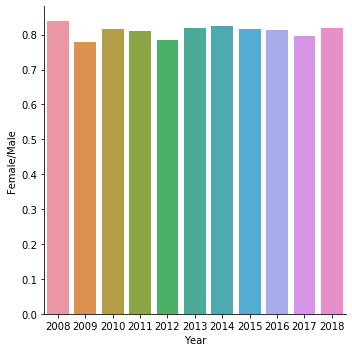

In [150]:
g = sns.catplot(y='Female/Male', x="Year", data=scores,
                kind="bar")

## 7.3. Wage Predictor
Below is the read datafile for 2018 which allows a user of the notebook to input a set of conditions to the various features in order to display the median value under those conditions as well as a box and whisker plot of everyone falling under the specified set of categories. Given the low level of importance of the state and race features, they were excluded for this simple predictor.

In [135]:
start_time = time.time()
useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
               'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST']
path = r'data/2018'
PUS_18 = pd.concat([pd.read_csv(f, usecols=useful_cols) for f in glob.glob(
    path + "/*.csv", recursive=True)], ignore_index=True)
print(PUS_18.shape)
print(" %s min" % round(((time.time() - start_time)/60), 2))

(3214539, 10)
 0.64 min


In [136]:
test_PUS = pp_pipeline(PUS_18)

In [137]:
def df_isolate(df, sex, age, edu, job):
    wanted_df = df.loc[(df.SEX == sex) &
                             (df.AGEB == age) &
                             (df.EDU == edu) &
                             (df.JOB == job)
                             ].copy()
    return wanted_df

Enter gender:
            1 = Male
            2 = Female
            Entered: 1
Enter age bin:
            1 = 18-25
            2 = 26-35
            3 = 36-45 or 66-70
            4 = 46-65
            Entered: 1
Enter level of eduation:
            1 = No HS or HS Equivalent
            2 = Some College or Associates
            3 = Bachlors Degree
            4 = Masters Degree
            5 = Doctorate or Higher
            Entered: 4
Enter job industry:
            1 = Production, Service, Transportation
            2 = Military, Sales, Maintenance
            3 = Arts, Healthcare,
            4 = Science, Business
            Entered: 4
Total Matches: 452 people
Median Wage: $ 60000


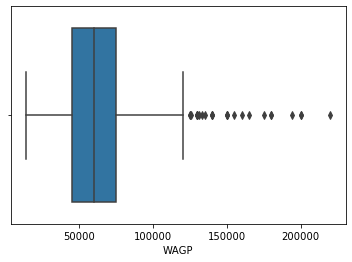

In [138]:
Sex = int(input("""Enter gender:
            1 = Male
            2 = Female
            Entered: """))
Age = int(input("""Enter age bin:
            1 = 18-25
            2 = 26-35
            3 = 36-45 or 66-70
            4 = 46-65
            Entered: """))
Edu = int(input("""Enter level of eduation:
            1 = No HS or HS Equivalent
            2 = Some College or Associates
            3 = Bachlors Degree
            4 = Masters Degree
            5 = Doctorate or Higher
            Entered: """))
Job = int(input("""Enter job industry:
            1 = Production, Service, Transportation
            2 = Military, Sales, Maintenance
            3 = Arts, Healthcare,
            4 = Science, Business
            Entered: """))

User_imput = df_isolate(test_PUS, Sex, Age, Edu, Job)
print("Total Matches: %s people" % User_imput.WAGP.count())
print("Median Wage: $",int(User_imput.WAGP.median()))
ax = sns.boxplot(x=User_imput["WAGP"])